In [1]:
import numpy as np
import os, glob
import gdal, osr # python2.7
# import rasterio # python2.7
# from osgeo import gdal
import MisrToolkit as Mtk # python2.7
from MisrToolkit import * # 

## my assumptions

In [2]:
path_num = 180
misr_img_res = (512, 2048)
# img_nrows = misr_img_dims[0]
# img_ncols = misr_img_dims[1]
resolution_meter = 275

In [3]:
hdf_file = "/Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/hdf_dir.nosync/MISR_AM1_GRP_ELLIPSOID_GM_P180_O088147_AN_F03_0024.hdf"
os.path.isfile(hdf_file)

True

## read block-1 data

In [4]:
b1_region = Mtk.MtkRegion(path_num, 1, 1)
input_file = Mtk.MtkFile(hdf_file)

MtkField = input_file.grid("RedBand").field("Red Radiance")  # Red Radiance/RDQI- what is the difference?

srcdata = MtkField.read(b1_region).data()

print(srcdata.ndim)
print(srcdata.min())
print(srcdata.max())

# b1_region.block_range
# b1_data = Mtk

2
0.0
55.21635


## look at data array as img

<Figure size 432x288 with 0 Axes>

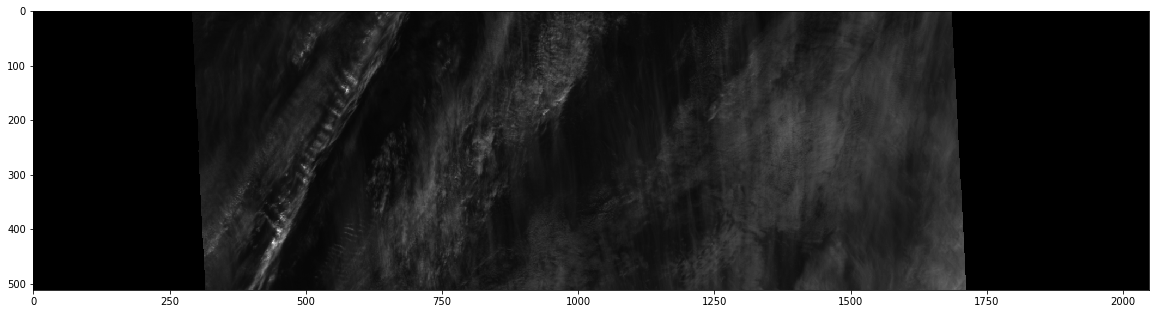

In [5]:
%matplotlib inline 

from matplotlib import pyplot as plt  #  pyplot uses the actual RGB values as they are, more accurate than PIL
plt.gray() # This will show the images in grayscale as default

plt.figure(figsize=(20,20))  # set the figure size

plt.imshow(srcdata)
plt.show()



## extract projection information

In [6]:
proj_param_obj = Mtk.MtkProjParam(hdf_file)

print("-> ulc: (%d,%d) meters" % proj_param_obj.ulc)

print("-> projection parameter code: %s" % proj_param_obj.projcode)
# b1_ulc_som = proj_param_obj.ulc  # order: (X,Y) = (lon,lat)
# b1_lrc_som  = proj_param_obj.lrc  # order: (X,Y) = (lon,lat)

# # ground truth for reference
# print("-> ulc SOM from hdf file: (%d,%d) meters" % b1_ulc_som)
# print("-> lrc SOM from hdf file: (%d,%d) meters" % b1_lrc_som)

#~ get proj res
proj_param_res = proj_param_obj.resolution
print("-> resolution from projParam: %d" % proj_param_res)

#~ get offset values
offset = proj_param_obj.reloffset
print("-> number of offset pixels: %s" % len(offset))

# print("-> offset/#pixels of origin/ulc of each block relative to the origin of its top block:")
# print(offset)

proj_param_list = proj_param_obj.projparam
for ele in proj_param_list:
    print(ele)

inclination_angle = proj_param_list[3]
print("inclination angle= %s" % inclination_angle)

ascending_node_lon = proj_param_list[4]
print("lon of ascending node= %s" %ascending_node_lon)

-> ulc: (7460750,1090650) meters
-> projection parameter code: 22
-> resolution from projParam: 1100
-> number of offset pixels: 179
6378137.0
-0.006694348
0.0
98018013.752
127045037.928
0.0
0.0
0.0
98.88
0.0
0.0
180.0
0.0
0.0
0.0
inclination angle= 98018013.752
lon of ascending node= 127045037.928


## bls to somxy

In [7]:
# #~ in MISR view frame==NorthDown, clockwise manner from ulc
# #~ img pixels are 0-based
# ulc = bls_to_somxy(path_num, 275, 1, 0, 0)       
# urc = bls_to_somxy(path_num, 275, 1, 0, 2047)
# lrc = bls_to_somxy(path_num, 275, 1, 511, 2047)
# llc = bls_to_somxy(path_num, 275, 1, 511, 0)

# #~ note: in MISR perspective which is North-down 
# print("ulc: %d, %d" % ulc)
# print("urc: %d, %d" % urc) 
# print("lrc: %d, %d" % lrc) 
# print("llc: %d, %d" % llc) 

## somxy to latlon

In [8]:
# #~ in MISR view frame==NorthDown, clockwise manner from ulc
# ulc_latlon_dd = somxy_to_latlon(path_num, ulc[0], ulc[1])
# urc_latlon_dd = somxy_to_latlon(path_num, urc[0], urc[1])
# lrc_latlon_dd = somxy_to_latlon(path_num, lrc[0], lrc[1])
# llc_latlon_dd = somxy_to_latlon(path_num, llc[0], llc[1])

# print(ulc_latlon_dd)
# print(urc_latlon_dd)
# print(lrc_latlon_dd)
# print(llc_latlon_dd)

## extract block corners: bls to latlon

In [15]:
#~ in MISR view frame == North-down, clockwise manner from ulc
#~ img pixels are 0-based

img_ulc_dd = bls_to_latlon(180, 275, 20, 0, 0)       
img_urc_dd = bls_to_latlon(180, 275, 20, 0, 2047)
img_lrc_dd = bls_to_latlon(180, 275, 20, 511, 2047)
img_llc_dd = bls_to_latlon(180, 275, 20, 511, 0)

#~ note: from MISR perspective which is North-down 
print("img_ulc: (%f, %f)" % img_ulc_dd)
print("img_urc: (%f, %f)" % img_urc_dd) 
print("img_lrc: (%f, %f)" % img_lrc_dd) 
print("img_llc: (%f, %f)" % img_llc_dd) 

img_ulc: (84.215615, 108.771986)
img_urc: (79.192008, 111.663721)
img_lrc: (79.047324, 105.044854)
img_llc: (83.950756, 96.827682)


## calculate pixel size from ulc and lrc

In [10]:
#~ pixel size 
# img_ncols = 2048
# img_nrows = 512

#x-component of the pixel width (x scale)
pixel_w = (img_ulc_dd[1]-img_lrc_dd[1])/misr_img_res[1]  # pixel-x-size; rasterx, ppx
# y-component of the pixel height (y scale)
pixel_h = (img_ulc_dd[0]-img_lrc_dd[0])/misr_img_res[0]  # pixel-y-size, rastery, ppy
#~ create a tuple
pixel_size = (pixel_w, pixel_h)

print("-> pixel size (w,h) in degrees:")
print (pixel_size) # W-res, H-res --> lon-lat

-> pixel size (w,h) in degrees:
(0.006219830389738862, 0.0009208472018909508)


## raster name

In [11]:
raster_fullPath = "/Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/raster_dir.nosync/path_180_b1.tif"

## array to raster- NorthUp notation

In [12]:
def array2raster_NorthUp_LRCOrigin(ulc_lat, ulc_lon, pixel_w, pixel_h, img_nrows, img_ncols, raster_fullPath, input_array):
    "this function writes out the array-image as a georeferenced tif file."
    "we use NorthUp notation in this function which assumes lookig at blocks in world crs/frame." 
    "in this notation in order to write an array, MISR lrc == raster ulc."

    print("-> using North-up (world CRS perspective) + lrc as the origin of each block.")

    # reversed_arr = roughness_array[::-1] # reverse array so the tif looks like the array
    #~ define band and numeric type
    bands_num = 1
    datatype = gdal.GDT_Float32
    out_epsg = 4326  # EPSG code for lat-lon # what is the ellipsoid information of this ellipsoid???
    x_rotation = 0 # 0 degrees if image is “North Up” , not supported!
    y_rotation = 0 # 0 degrees if image is “North Up” , not supported!
    
    print('-> input2raster: to write the raster we use MISR lrc as GDAL/world frame block origin (ulc)- lat,lon= %f, %f. ' % (ulc_lat, ulc_lon))

    #~ note: we define the area that will be covered to define the geo tranform; # units in degrees because our output raster is in lat-lon
    #~ parameter order: top left x (meters or degrees), w-e pixel resolution, rotation, top left y (meters or degrees), rotation, n-s pixel resolution; output units in map coords
    geotransform_matrix = (ulc_lon, pixel_w, x_rotation, ulc_lat, y_rotation, -pixel_h) # note: negative flips the img over y-axis (in img coord. sys.), because we count from the UL corner to down

    #~ create output raster and setup driver=GTiff
    driver = gdal.GetDriverByName('GTiff')  # Initialize driver
    out_raster = driver.Create(raster_fullPath, img_ncols, img_nrows, bands_num, datatype)  # create output raster (img+georefrenced info) dataseet to write data into it (raster_fullPath, ncols_rough_arr, nrows_rough_arr, bands, dtype-> GDAL data type arg)
    out_raster.SetGeoTransform(geotransform_matrix)  # Set the affine transformation coefficients == Specify raster coordinates

    outband = out_raster.GetRasterBand(bands_num)
    outband.WriteArray(input_array)

    #~ define coord. ref. system.
    crs = osr.SpatialReference()
    #~ if we have EPSG code
    crs.ImportFromEPSG(out_epsg)
    
    #~ if we have projParams
#     projparam_string = "+units=degree +datum=WGS84 +ellps=WGS84" #+lon_0=127.045037.928 " #"+lat_0=40.000  +lat_1=40.450  +lat_2=36.450  +proj=misrsom +path=180 "
#     crs.ImportFromProj4(projparam_string)
    #~ check the crs
    print("-> check output crs/frame, it should not be empty: %s" % crs.ExportToWkt())
    
    out_raster.SetProjection(crs.ExportToWkt())
    outband.FlushCache()

    #~ Once we're done, close the dataset properly
    out_raster = None
    outband = None
    print("-> FINISHED SUCCESS!")
    print(raster_fullPath)
    return 0

In [13]:
#~ we use MISR img lrc == raster ulc to write raster.
array2raster_NorthUp_LRCOrigin(img_lrc_dd[0], img_lrc_dd[1], pixel_size[0], pixel_size[1], misr_img_res[0], misr_img_res[1], raster_fullPath, srcdata)

-> using North-up (world CRS perspective) + lrc as the origin of each block.
-> input2raster: to write the raster we use MISR lrc as GDAL/world frame block origin (ulc)- lat,lon= 65.752107, -178.841471. 
-> check output crs/frame, it should not be empty: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
-> FINISHED SUCCESS!
/Users/ehsanmos/Documents/RnD/Ehsan_lab_MISR/raster_dir.nosync/path_180_b1.tif


0